In [1]:
# Machine-Learning-Spectrogram-CNN-Project

# For this project, the free-spoken-digit-dataset was used.

# I do not own the rights to this dataset.
# This was obtained from a free open source community and can
# be found at the following sources:

# GitHub: Jakobovski
# https://github.com/Jakobovski/free-spoken-digit-dataset

# Kaggle: Jose R. Zapata
# https://www.kaggle.com/datasets/joserzapata/free-spoken-digit-dataset-fsdd

%reset
from sklearnex import patch_sklearn
patch_sklearn()
import os, wave, pylab, shutil
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from pathlib import Path
from tqdm import tqdm

Nothing done.


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
input_folder = './free-spoken-digit-dataset/recordings/'
output_folder = './free-spoken-digit-dataset/working/'
figsize = (12, 12)

data_folder = os.listdir(input_folder)
for i in range(10):
    print(data_folder[i])

0_george_0.wav
0_george_1.wav
0_george_10.wav
0_george_11.wav
0_george_12.wav
0_george_13.wav
0_george_14.wav
0_george_15.wav
0_george_16.wav
0_george_17.wav


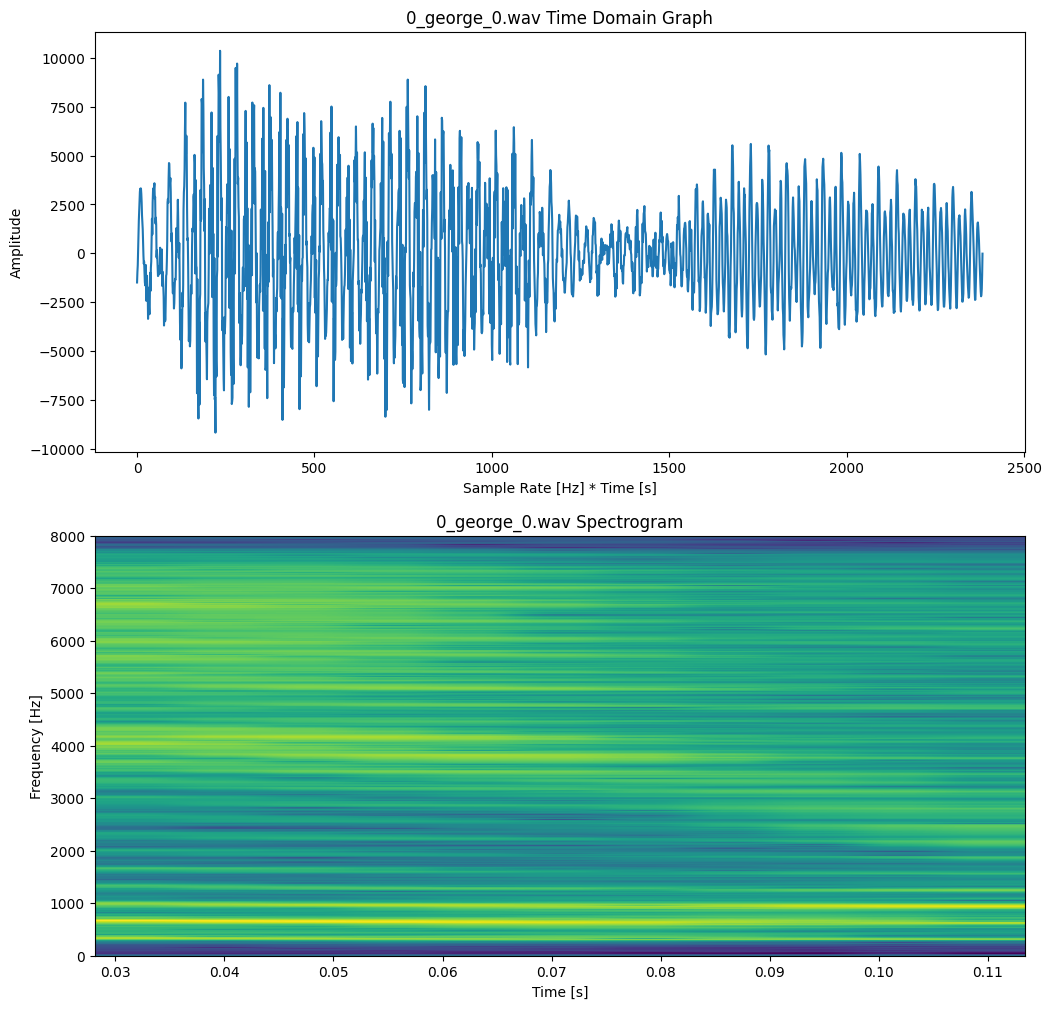

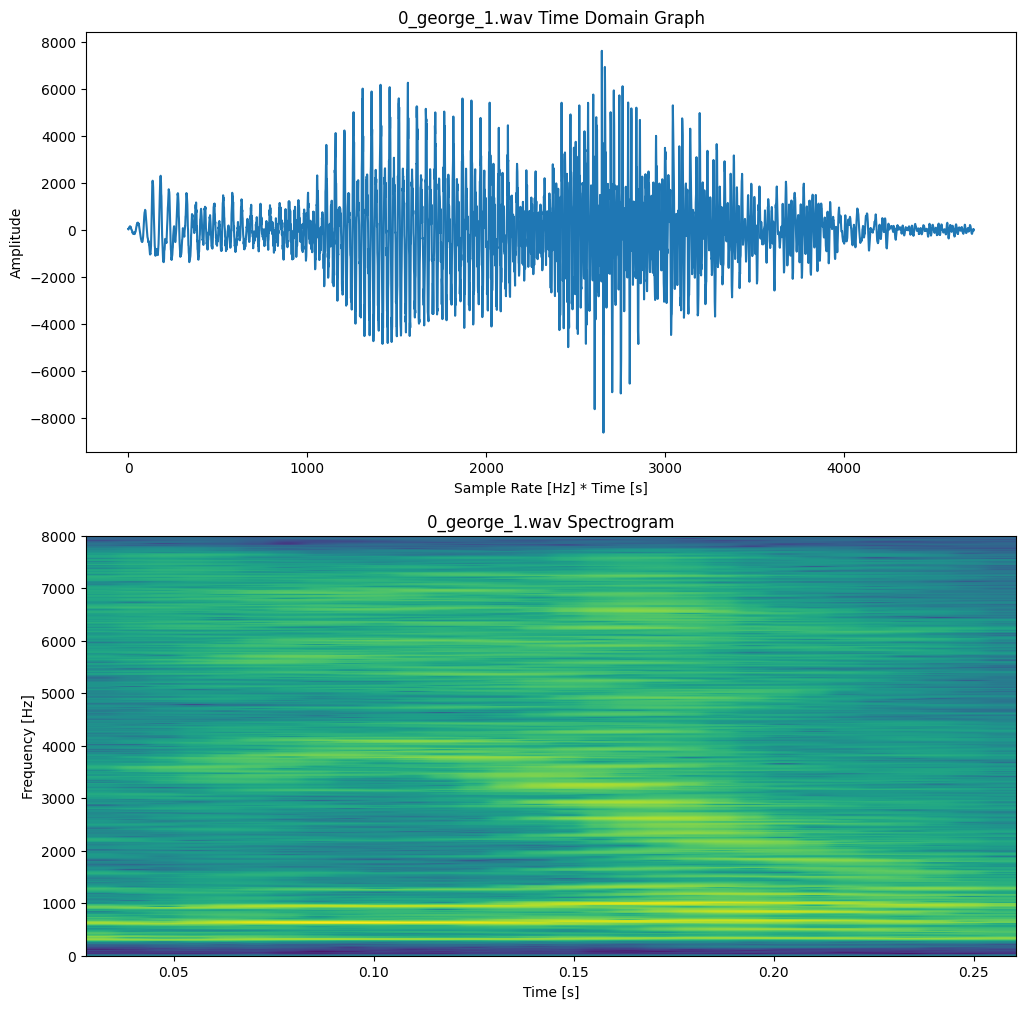

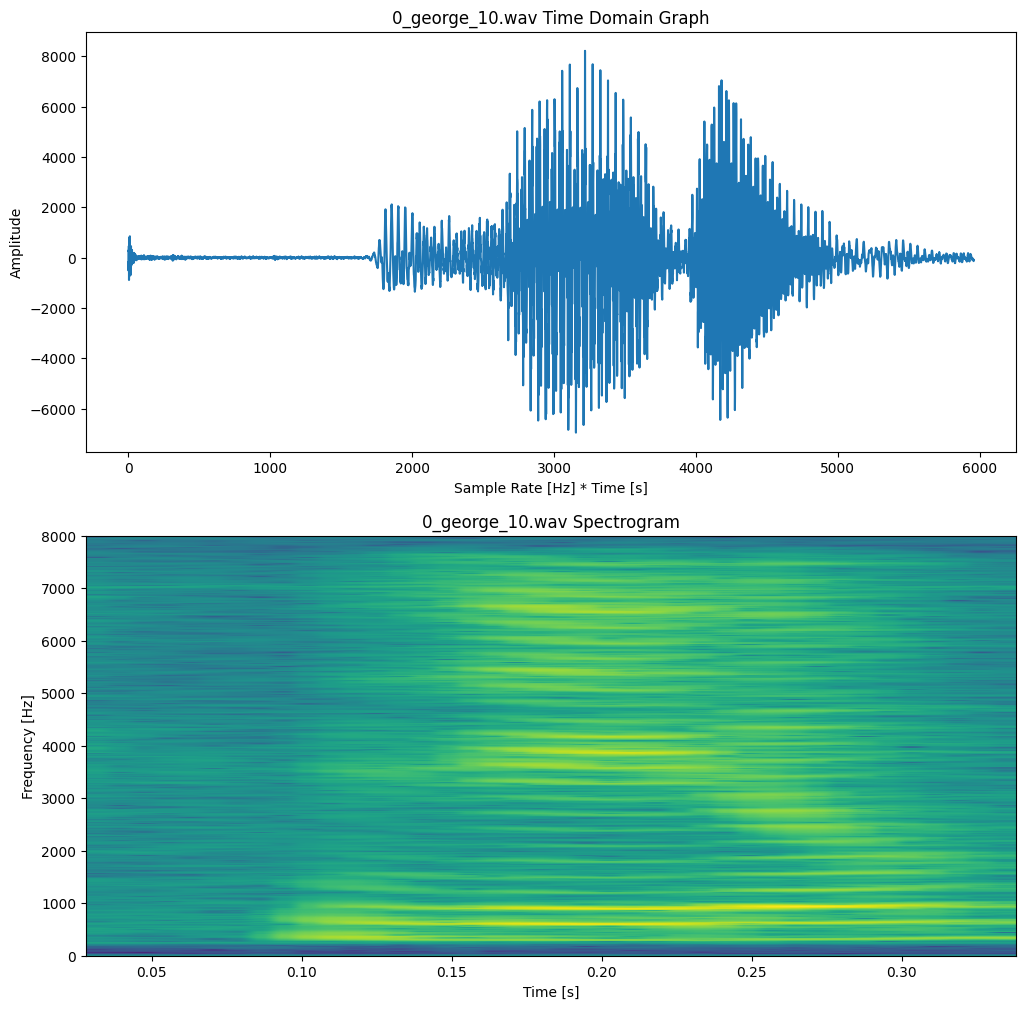

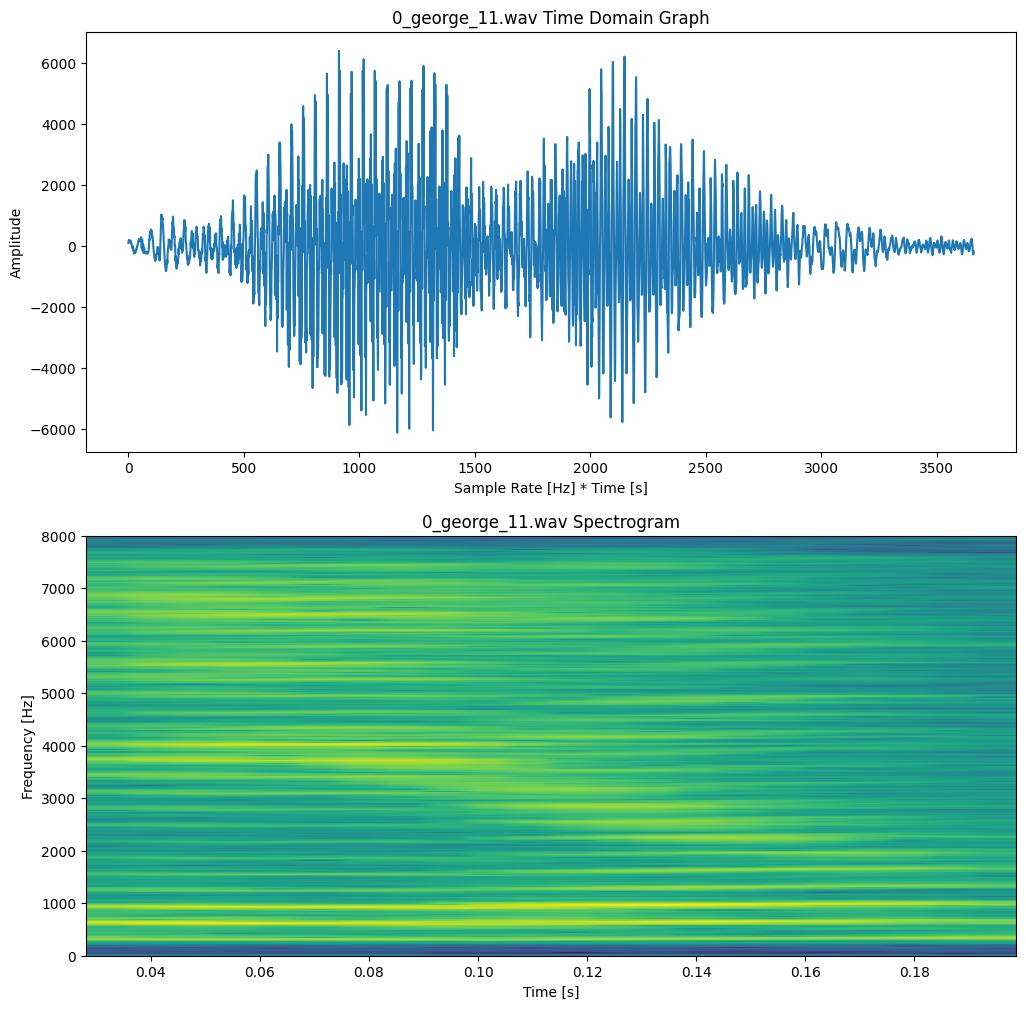

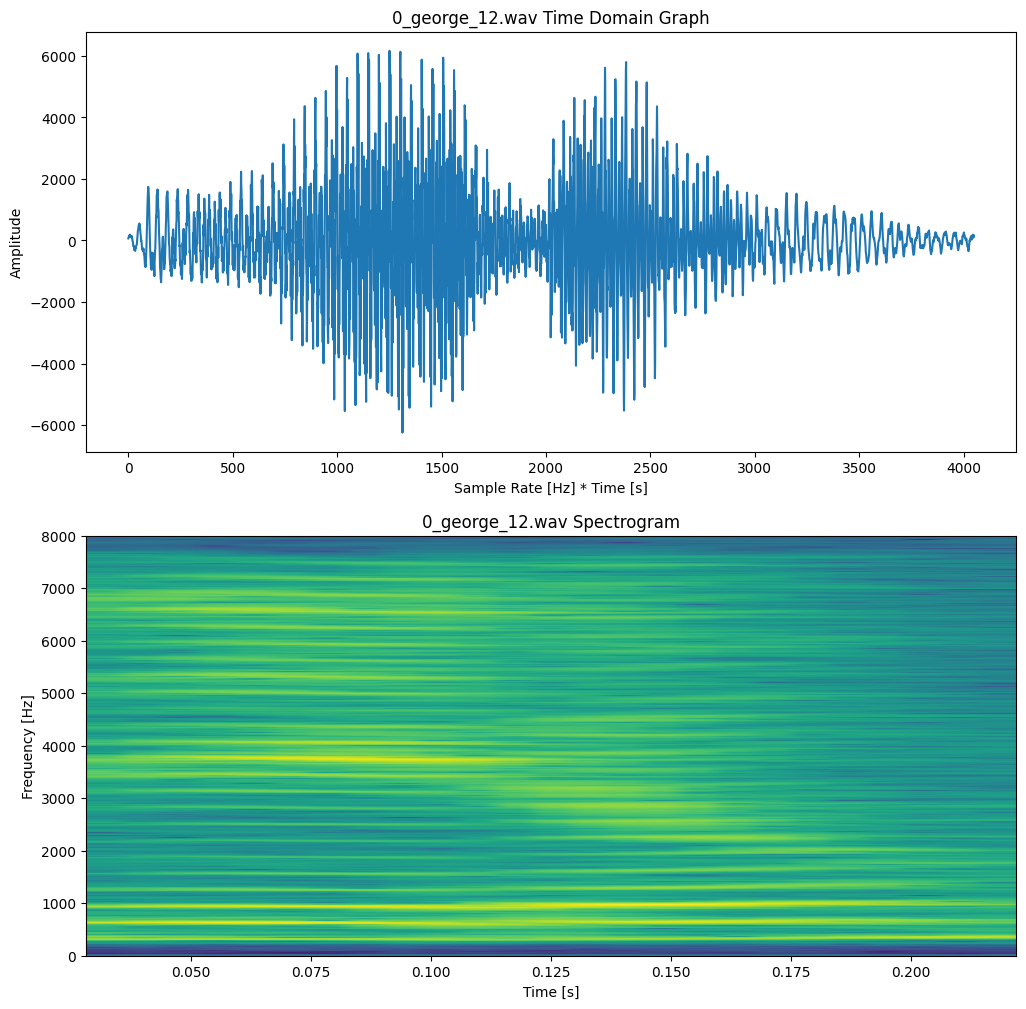

In [3]:
for i in range(5):
    wav_file = wave.open(os.path.join(input_folder, data_folder[i]), 'r')
    sr = 16000
    sign = np.frombuffer(wav_file.readframes(sr), dtype=np.int16)
    plt.figure(figsize=figsize)
    plt.subplot(2, 1, 1)
    plt.plot(sign)
    plt.title(data_folder[i] + ' Time Domain Graph')
    plt.xlabel('Sample Rate [Hz] * Time [s]')
    plt.ylabel('Amplitude')
    
    plt.subplot(2, 1, 2)
    plt.specgram(sign, NFFT=1024, Fs=sr, noverlap=900)
    plt.title(data_folder[i] + ' Spectrogram')
    plt.xlabel('Time [s]')
    plt.ylabel('Frequency [Hz]')

  5%|▍         | 147/3000 [00:20<06:31,  7.29it/s]


KeyboardInterrupt: 

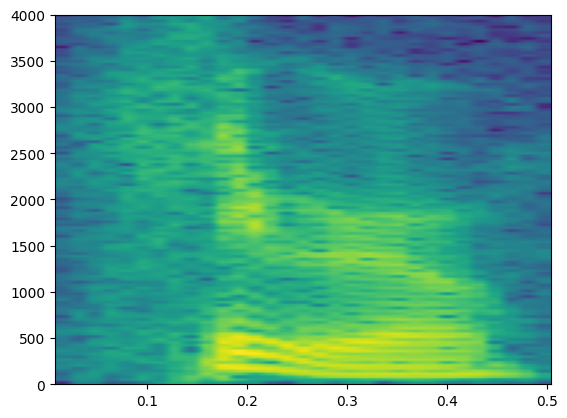

In [4]:
def get_signal_details(wav_file):
    sign = wave.open(wav_file, 'r')
    fr = sign.readframes(-1)
    ampl = pylab.frombuffer(fr, 'int16')
    fr_rate = sign.getframerate()
    sign.close()
    return ampl, fr_rate

if not os.path.exists(os.path.join(output_folder, 'audio-images')):
    os.mkdir(os.path.join(output_folder, 'audio-images'))

for file in tqdm(os.listdir(input_folder)):
    if 'wav' in file:
        file_path = os.path.join(input_folder, file)
        file_stem = Path(file_path).stem
        file_dir = f'class_{file_stem[0]}'
        out_dir = os.path.join(os.path.join(output_folder, 'audio-images'), file_dir)
        out_path = os.path.join(out_dir, file_stem)
        if not os.path.exists(out_path + '.png'):
            if not os.path.exists(out_dir):
                os.mkdir(out_dir)
            file_stem = Path(file_path).stem
            ampl, fr_rate = get_signal_details(file_path)
            pylab.specgram(ampl, Fs=fr_rate)
            pylab.savefig(f'{out_path}.png')
            pylab.close()

folder_list = os.listdir(os.path.join(output_folder, 'audio-images'))
print('Classes: \n')
for i in range(10):
    print(folder_list[i])

folder_list = os.listdir(os.path.join(output_folder, 'audio-images/class_1'))
print('\nA few example files:\n')
for i in range(10):
    print(folder_list[i])

Found 3000 files belonging to 10 classes.
Using 2400 files for training.
Using 600 files for validation.


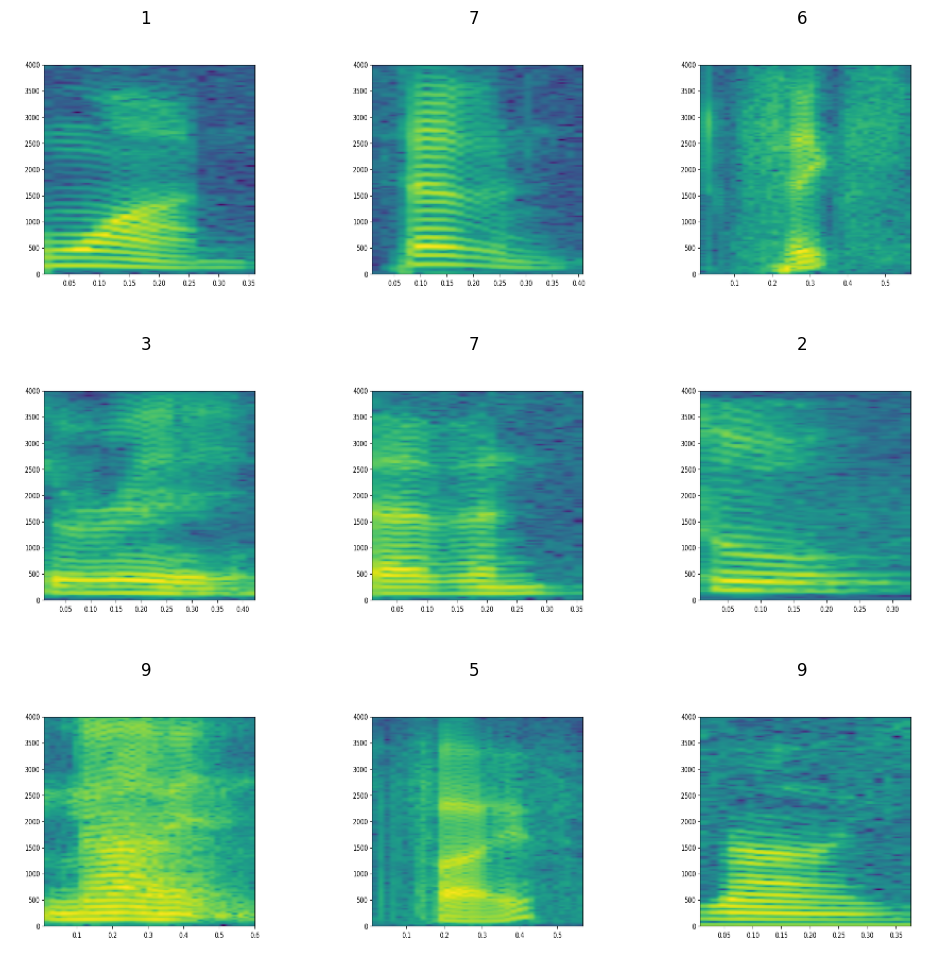

In [ ]:
img_width = 256
img_height = 256
batch_size = 32
n_channels = 3
n_classes = 10

train_set, validation_set = tf.keras.preprocessing.image_dataset_from_directory(batch_size=batch_size, validation_split=0.2,
    directory=os.path.join(output_folder, 'audio-images'), shuffle=True, color_mode='rgb',
    image_size=(img_height, img_width), subset='both', seed=0)

plt.figure(figsize=figsize)
for img, labels in train_set.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(img[i].numpy().astype('uint8'))
        plt.title(int(labels[i]))
        plt.axis('off')
plt.show()

In [ ]:
def preproc(dataset, augment=False):
    rescale = tf.keras.Sequential([tf.keras.layers.experimental.preprocessing.Rescaling(1./255)])
    flip_rot = tf.keras.Sequential([tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)])
    dataset = dataset.map(map_func=lambda x, y: (rescale(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)
    if augment: dataset = dataset.map(map_func=lambda x, y: (flip_rot(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)
    return dataset

train_set = preproc(train_set, augment=False)
validation_set = preproc(validation_set, augment=False)

In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(shape=(img_height, img_width, n_channels)))
model.add(tf.keras.layers.Conv2D(32, 3, strides=2, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(n_classes, activation='softmax'))

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.RMSprop(),
    metrics=['accuracy'],
)

In [ ]:
history = model.fit(train_set, epochs=50, validation_data=validation_set)

Epoch 1/50
75/75 [==============================] - 14s 71ms/step - loss: 0.6589 - accuracy: 0.7962 - val_loss: 4.2578 - val_accuracy: 0.0917
Epoch 2/50
75/75 [==============================] - 5s 62ms/step - loss: 0.2301 - accuracy: 0.9404 - val_loss: 5.4916 - val_accuracy: 0.0917
Epoch 3/50
75/75 [==============================] - 5s 60ms/step - loss: 0.1648 - accuracy: 0.9658 - val_loss: 3.1921 - val_accuracy: 0.1933
Epoch 4/50
75/75 [==============================] - 5s 60ms/step - loss: 0.0995 - accuracy: 0.9808 - val_loss: 2.5040 - val_accuracy: 0.3017
Epoch 5/50
75/75 [==============================] - 5s 60ms/step - loss: 0.0600 - accuracy: 0.9904 - val_loss: 2.7066 - val_accuracy: 0.1950
Epoch 6/50
75/75 [==============================] - 5s 60ms/step - loss: 0.0369 - accuracy: 0.9950 - val_loss: 0.6827 - val_accuracy: 0.7700
Epoch 7/50
75/75 [==============================] - 5s 59ms/step - loss: 0.0308 - accuracy: 0.9929 - val_loss: 0.4181 - val_accuracy: 0.8683
Epoch 8/50
7

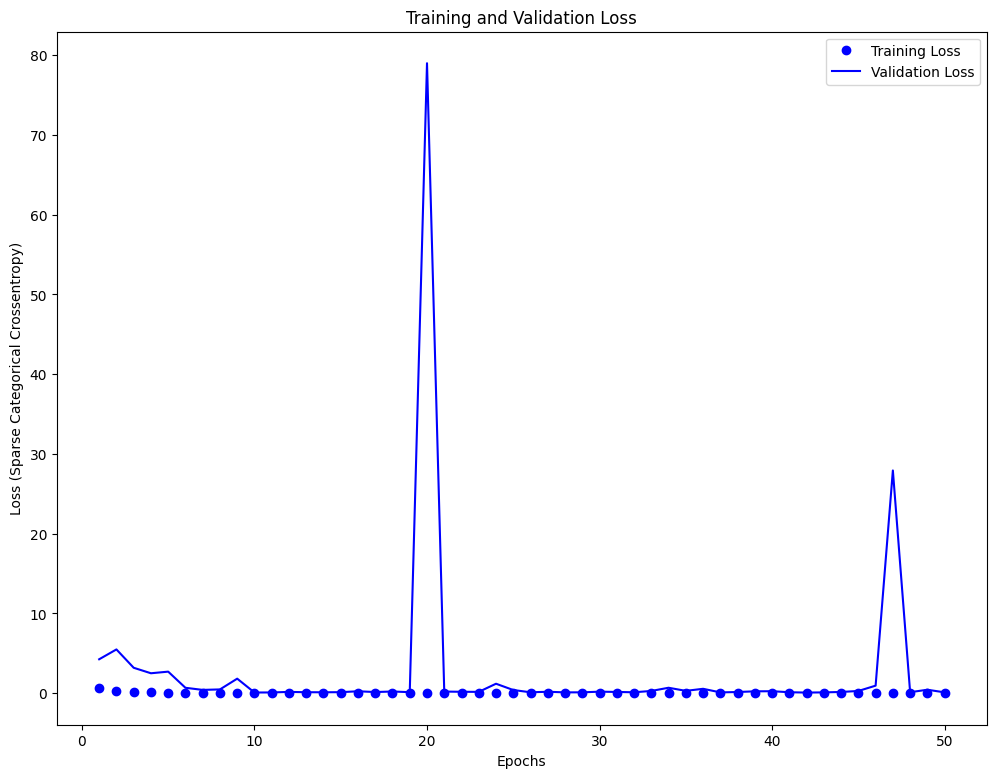

In [ ]:
loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(12, 9))
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, validation_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (Sparse Categorical Crossentropy)')
plt.legend()

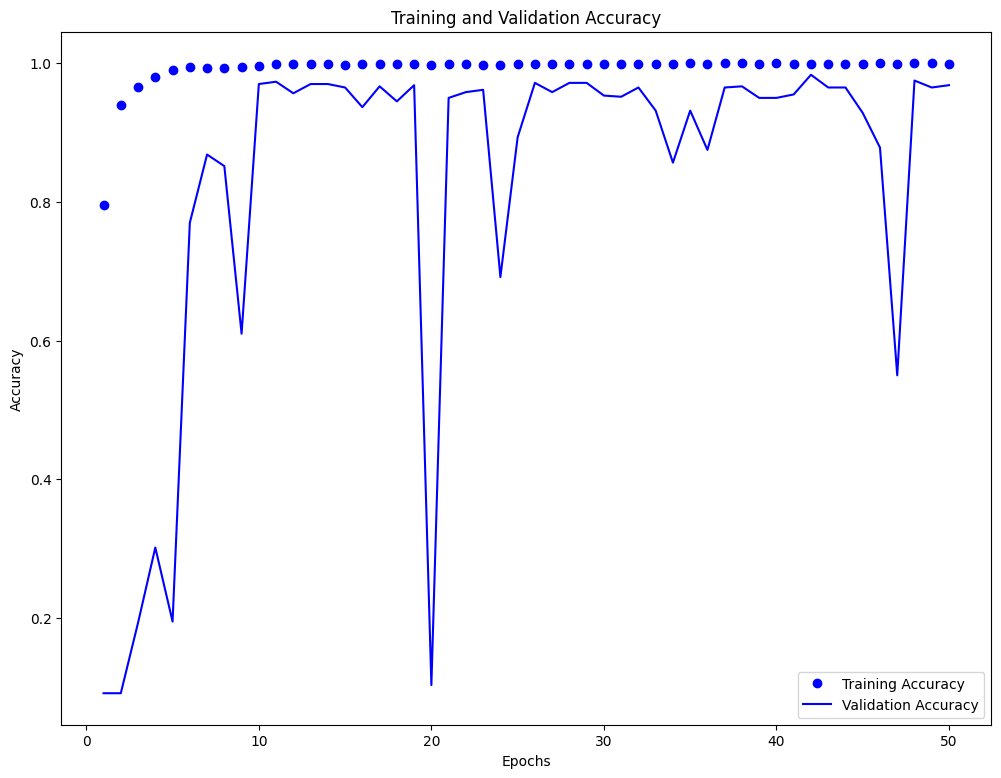

In [ ]:
accur = history.history['accuracy']
validation_accur = history.history['val_accuracy']
epochs = range(1, len(accur) + 1)

plt.figure(figsize=(12, 9))
plt.plot(epochs, accur, 'bo', label='Training Accuracy')
plt.plot(epochs, validation_accur, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [ ]:
eval_loss, eval_accur = model.evaluate(validation_set, verbose=0)
print(f'Final Loss:\t{eval_loss}')
print(f'Final Accuracy:\t{eval_accur}')
shutil.rmtree(output_folder + 'audio-images')

Final Loss:	0.10986759513616562
Final Accuracy:	0.9683333039283752
